<a href="https://colab.research.google.com/github/seoyujiin/esaa_ob/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_7%EC%9E%A5_%EC%95%99%EC%83%81%EB%B8%94_%ED%95%99%EC%8A%B5%EA%B3%BC_%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**CHAPTER 7 앙상블 학습과 랜덤 포레스트**

* 앙상블 학습: 일련의 예측기(즉, 분류나 회귀 모델)로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있음. 일련의 예측기를 앙상블이라고 부르기 때문에 이를 앙상블 학습이라고 함
  * ex) 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정트리 분류기를 훈련시킬 수 있음. 예측을 하려면 모든 개별 트리의 예측을 구하면 되고 그런 다음 가장 많은 선택을 받은 클래스를 예측으로 삼음
  * 결정트리의 앙상블을 랜덤 포레스트라고 함
* 이 장에서는 배깅, 부스팅, 스태킹 등 가장 인기 있는 앙상블 방법을 설명


###**7.1 투표 기반 분류기**

* 직접 투표 분류기: 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것(다수결 투표로 정해지는 분류기)
* 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다도 정확도가 높을 경우가 많음
* 각 분류기가 약한 학습기일지라도 충분하게 많고 다양하다면 앙상블은 강한 학습기가 될 수 있음
* 하지만 이는 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없어야 가능
* 앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능 발휘(각기 다른 알고리즘으로 학습시켜 다양한 분류기를 얻으면 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도 향상시킴)

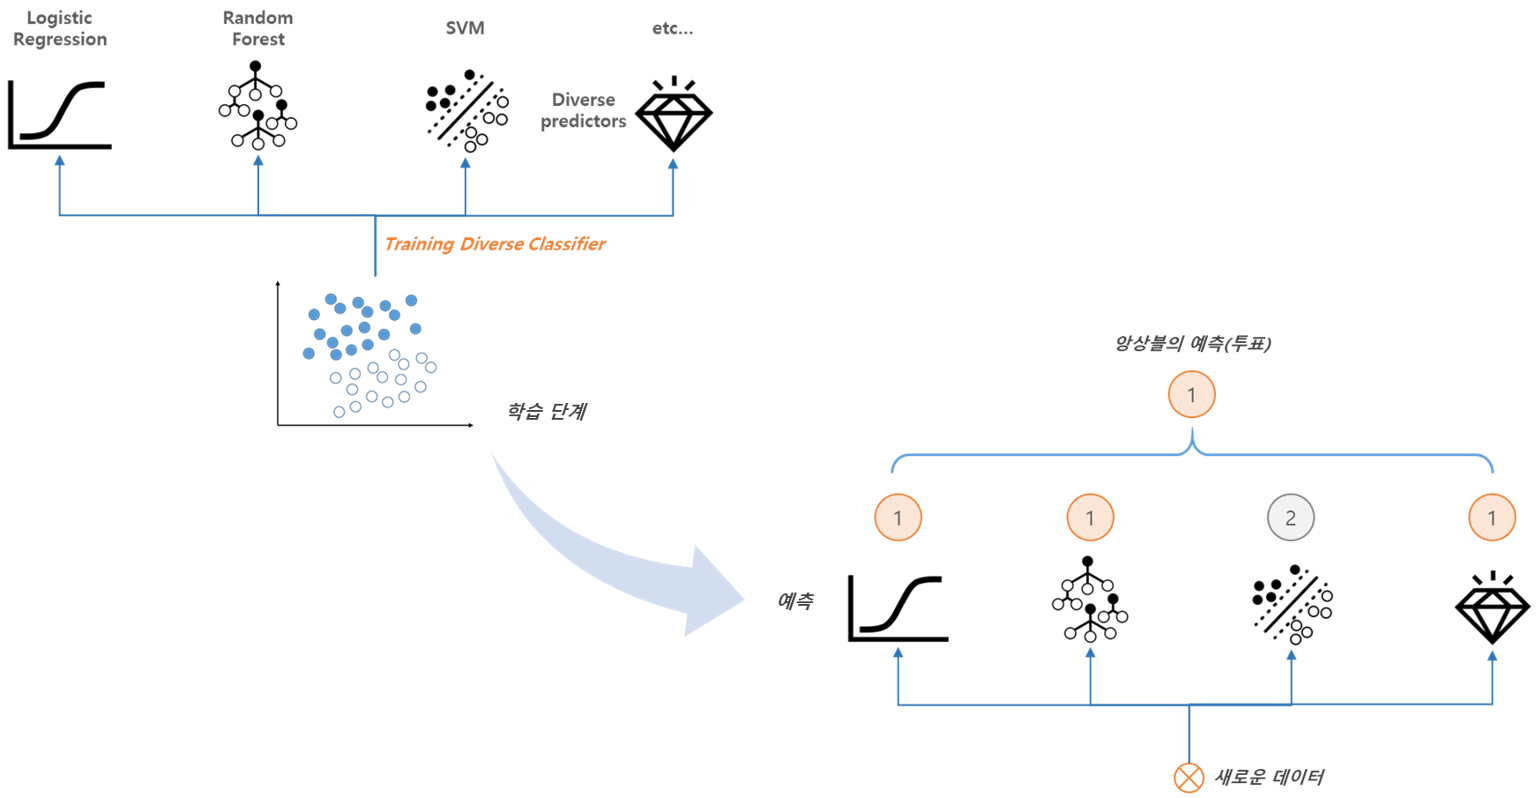

In [ ]:
# moons 데이터 불러오기
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# 여러 분류기를 조합하여 사이킷런의 투표 기반 분류기(VotingClassifier)를 만들고 훈련시킴
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

# VotingClassifier에서 voting='hard' 인 경우 각 분류기의 예측값(레이블)을 가지고 다수결 투표를 통해 최종 앙상블 예측이 이루어짐
voting_clf = VotingClassifier(estimators=[('lr',log_clf), ('rf',rnd_clf), ('svc',svm_clf)], voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [ ]:
# 각 분류기의 테스트셋 정확도 확
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.904


→ 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높음

* 간접 투표: 모든 분류기가 클래스의 확률을 예측할 수 있으면(즉 predict_proba() 메서드가 있으면), 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있음
  * 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능 높음
  * 이 방식을 사용하기 위해서는 voting="hard"를 voting="soft"로 바꾸고 모든 분류기가 클래스의 확률을 추정할 수 있으면 됨


##**7.2 배깅과 페이스팅**

* 다양한 분류기를 만드는 한 가지 방법은 각기 다른 훈련 알고리즘을 사용하는 것, 또 다른 방법은 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것
* 배깅(bagging, bootstrap aggregating의 줄임말): 훈련 세트에서 중복을 허용하여 샘플링하는 방식
* 페이스팅(pasting): 중복을 허용하지 않고 샘플링하는 방식
* 배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있지만 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링할 수 있음

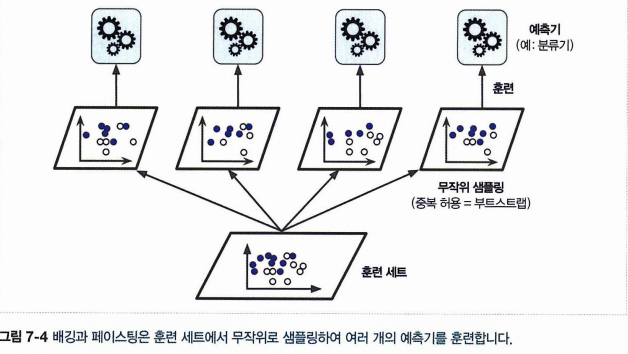

* 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦
* 수집 함수는 전형적으로 분류일 때는 통계적 최빈값이고 회귀에 대해서는 평균을 계산
* 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소함
* 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어듦


**7.2.1 사이킷런의 배깅과 페이스팅**

* 사이킷런은 배깅과 페이스팅을 위해 간편한 API로 구성된 BaggingClassifier(분류), BaggingRegressor(회귀) 제공


In [ ]:
# 결정 트리 분류기 500개의 앙상블 훈련시키는 코드
# 각 분류기는 훈련 세트에서 중복 허용하여 무작위로 선택된 100개의 샘플로 훈련됨(배깅의 경우, 페이스팅 사용하려면 bootstrap=False)
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)  # n_jobs: 사이킷런이 훈련과 예측에 사용할 CPU 코어 수 지정(-1로 지저앟면 가용한 모든 코어 사용)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

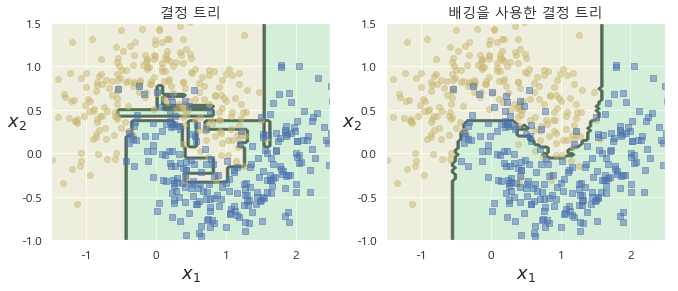

→ 단일 결정 트리의 결정 경계와 500개의 트리를 사용한 배깅 앙상블의 결정 경계 비교한 것

→ 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘됨

→ 앙상블은 비슷한 편향에서 더 작은 분산을 만듦(훈련 세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙)

* 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높음
* 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킴
* 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호
* 시간과 CPU 파워에 여유가 있다면 교차 검증으로 배깅과 페이스팅을 모두 평가해서 더 나은 쪽을 선택하는 것이 좋음

**7.2.2 oob 평가**

* 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있음
* BaggingClassifier는 기본값으로 중복을 허용하여 훈련 세트의 크기만큼인 $m$개 샘플을 선택하고 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미
* 선택되지 않은 훈련 샘플의 나머지 37%를 oob(out-of-bag) 샘플이라고 부름(예측기마다 남겨진 37%는 모두 다름)
* 예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있음
* 앙상블의 평가는 각 예측기의oob 평가를 평균하여 얻음
* 사이킷런에서 BaggingClassifier를 만들 때 oob_score=True로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행(평가 점수 결과는 oob_score_ 변수에 저장되어 있음)

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.904

→ oob 평가 결과를 보면 이 BaggingClassifier는 테스트 세트에서 약 89.9%의 정확도를 얻을 것으로 보임

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.888

→ 테스트 세트에서 90.4%의 정확도를 얻음

→ 매우 비슷!

* oob 샘플에 대한 결정 함수의 값도 oob_decision_function_ 변수에서 확인 가능
  * 결정 함수는 각 훈련 샘플의 클래스 확률을 반환(기반이 되는 예측기가 predict_proba() 메서드를 가지고 있기 때문에)

In [ ]:
bag_clf.oob_decision_function_
# oob 평가는 첫 번째 훈련 샘플이 양성 클래스에 속할 확률을 60.4%로 추정하고 있음

array([[0.35329341, 0.64670659],
       [0.35051546, 0.64948454],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06161137, 0.93838863],
       [0.32804233, 0.67195767],
       [0.00558659, 0.99441341],
       [1.        , 0.        ],
       [0.96470588, 0.03529412],
       [0.78021978, 0.21978022],
       [0.00520833, 0.99479167],
       [0.74444444, 0.25555556],
       [0.81818182, 0.18181818],
       [0.98159509, 0.01840491],
       [0.0255102 , 0.9744898 ],
       [0.00515464, 0.99484536],
       [0.97894737, 0.02105263],
       [0.93989071, 0.06010929],
       [0.99453552, 0.00546448],
       [0.02272727, 0.97727273],
       [0.33333333, 0.66666667],
       [0.88059701, 0.11940299],
       [1.        , 0.        ],
       [0.97687861, 0.02312139],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.67692308, 0.32307692],
       [0.

###**7.3 랜덤 패치와 랜덤 서브스페이스**

* BaggingClassifier는 특성 샘플링도 지원하며 샘플링은 max_features, bootstrap_features 두 매개변수로 조절됨
* 랜덤 패치 방식: 훈련 특성과 샘플을 모두 샘플링하는 것
* 랜덤 서브스페이스 방식: 훈련 샘플을 모두 사용하고(bootstrap=False, max_samples=1.0 설정) 특성은 샘플링(bootstrap_features=True 또는 max_features 1.0보다 작게 설정)하는 것
* 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춤


###**7.4 랜덤 포레스트**

* 랜덤 포레스트는 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블
* 전형적으로 max_samples를 훈련 세트의 크기로 지정함



In [ ]:
# 최대 16개의 리프 노드를 갖는 500개 트리로 이뤄진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련시키는 코드

from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

* RandomForestClassifier는 몇 가지 예외가 있지만 DecisionTreeClassifier의 매개변수와 앙상블 자체를 제어하는 데 필요한 BaggingClassifier의 매개변수를 모두 가지고 있음
* 랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입함
* 이는 결국 트리를 더욱 다양하게 만들고 다시 한번 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어냄


In [ ]:
# BaggingClassifier 사용해 앞의 RandomForestClasifier와 거의 유사하게 만든 것
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

**7.4.1 엑스트라 트리**

* 익스트림 랜덤 트리 앙상블(엑스트라 트리): 극단적으로 무작위한 트리의 랜덤 포레스트
* 모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠름


**7.4.2 특성 중요도**

* 랜덤 프레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것
* 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는 지 확인하여 특성의 중요도 측정(더 정확히 말하면 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같음)
* 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화함(이 값은 feature_importances_ 변수에 저장)
* 랜덤 포레스트는 특성을 선택해야 할 때 어떤 특성이 중요한지 빠르게 확인할 수 있어 매우 편리함

In [ ]:
# iris 데이터셋에 RandomForestClassifier를 훈련시키고 각 특성의 중요도 출력
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.09787067600236898
sepal width (cm) 0.022967437430552864
petal length (cm) 0.4341845920877039
petal width (cm) 0.44497729447937434


→ 가장 중요한 특성은 꽃잎의 길이(43%)와 너비(44%)이고 꽃받침의 길이와 너비는 비교적 덜 중요해보임(각각 9%와 2%)

###**7.5 부스팅**

* 부스팅: 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
  * 부스팅 방법에는 여러 가지가 있지만 가장 인기 있는 것은 에이다부스트와 그래디언트 부스팅


**7.5.1 에이다부스트**

* 에이다부스트: 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높여 이전 예측기를 보완하는 새로운 예측기를 만드는 방법
  * 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 되고 이것이 에이다부스트에서 사용하는 방식


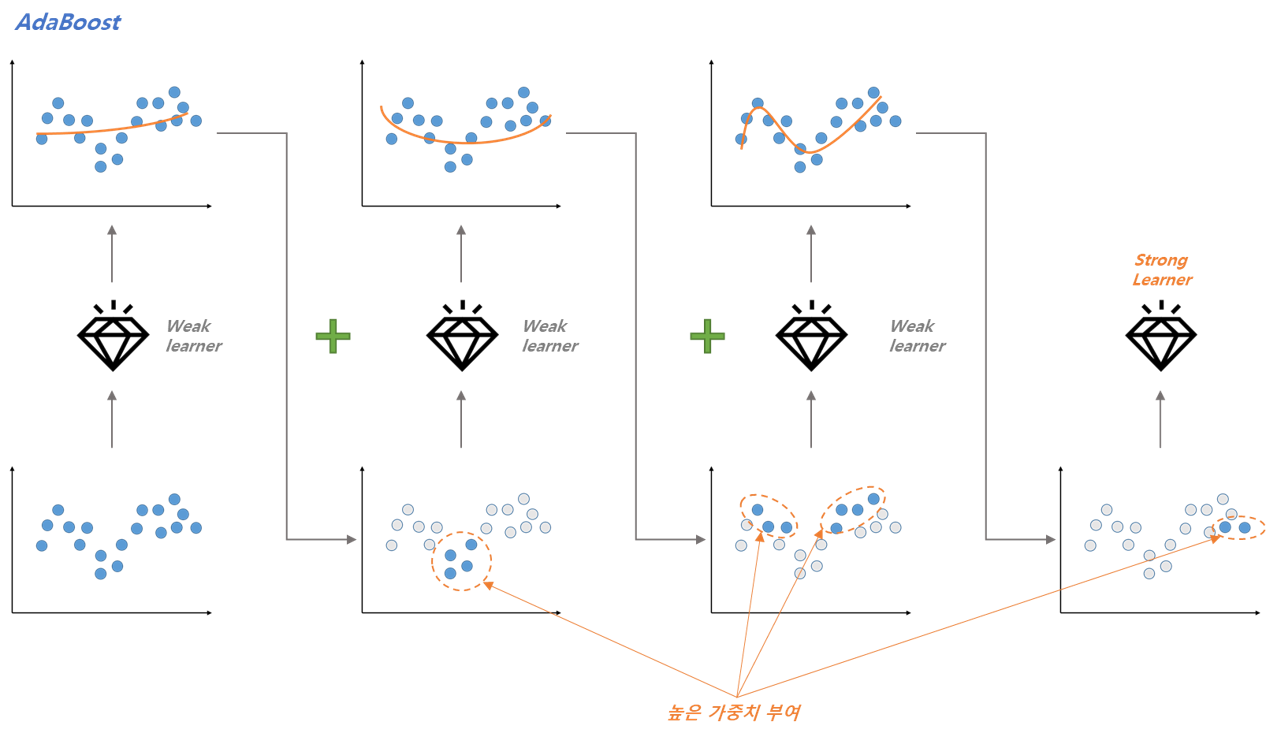

→ 예를 들어 에이다부스트 분류기를 만들 때 먼저 알고리즘이 기반이 되는 첫 번째 분류기를 훈련 세트에서 훈련시키고 예측을 만듦

→ 그다음에 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높임

→ 두 번째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만듦

→ 그다음에 다시 가중치를 업데이트하는 식으로 계속됨

연속된 예측기의 결정 경계

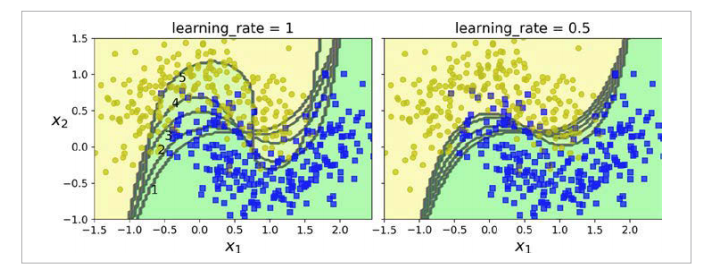

* 에이다부스트 알고리즘

① 먼저 각 데이터의 가중치 $w_i$는 $\frac{1}{m}$으로 초기화한다.


② 모델이 학습되고, 가중치가 적용된 에러율(weighted error rate)을 계산한다.

$$
r_j = \frac{\underset{ \hat y_j^{(i)} \neq y^{(i)} }{ \sum_{i=1}^{m}{w^{(i)}} } }{\sum_{i=1}^{m}{w^{(i)}}}
$$

- $\hat y_j^{(i)}$는 i번째 샘플에 대한 j번째 모델의 예측값이다.
- 위의 식은 $j$-번째 모델에서 실제값과 예측값이 같지 않은($ \hat y_j^{(i)} \neq y_i$) 샘플의 가중치($w^{(i)}$)의 합에서 전체 가중치의 합으로 나눈 비율을 에러율($r_t$)라고 정의한 것이다.

③ 각 $j$-번째 모델에 대한 가중치 $\alpha_t$는 다음과 같다.

$$
\alpha_j = \eta \log{\frac{1 - r_j}{r_j}}
$$

- $\eta$는 학습률(learning rate)을 의미하며, 논문에서는 학습률은 사용하지 않지만, scikit-learn의 [`AdaBoostClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)에서는 `learning_rate`의 인자가 있으며, 기본값은 `1`이다.
- 예측기가 정확할수록 가중치가 더 높아지게 된다. 만약 무작위로 예측하는 정도라면 가중치가 0에 가까울 것이다. 그러나 그보다 나쁘면(무작위 추측보다 정확도가 낮으면) 가중치는 음수가 된다.

④ 그다음 에이다부스트 알고리즘이 아래의 식을 통해 가중치($w_i$)를 업데이트한다. 즉, 잘못 분류된 샘플의 가중치가 증가된다.



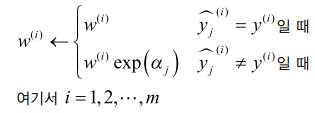

⑤ 그런 다음 모든 샘플의 가중치를 정규화한다.($\sum_{i=1}^{m}{w^{(i)}}$로 나눔)

⑥ 마지막으로 새 예측기가 업데이트된 가중치를 사용해 훈련되고 전체 과정이 반복된다.(새 예측기의 가중치가 계산되고 샘플의 가중치를 업데이트해서 또 다른 예측기를 훈련시키는 식) 이 알고리즘은 지정된 예측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지된다. 예측을 할 때 에이다부스트는 단순히 모든 예측기의 예측을 계산하고 예측기 가중치 $\alpha_j$를 더해 예측 결과를 만든다. 가중치 합이 가장 큰 클래스가 예측 결과가 된다.

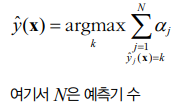

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

**7.5.2 그래디언트 부스팅**

* 그래디언트 부스팅: 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가하지 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킴

In [ ]:
# DecisionTreeRegressor를 훈련 세트(잡음이 섞인 2차 곡선 형태의 훈련 세트)에 학습
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [ ]:
# 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor 훈련시킴
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [ ]:
# 두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델 훈련시킴
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

→ 세 개의 트리를 포함하는 앙상블 모델이 생김

→ 새로운 샘플에 대한 예측을 만들려면 모든 트리의 예측을 더하면 됨

In [ ]:
# y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

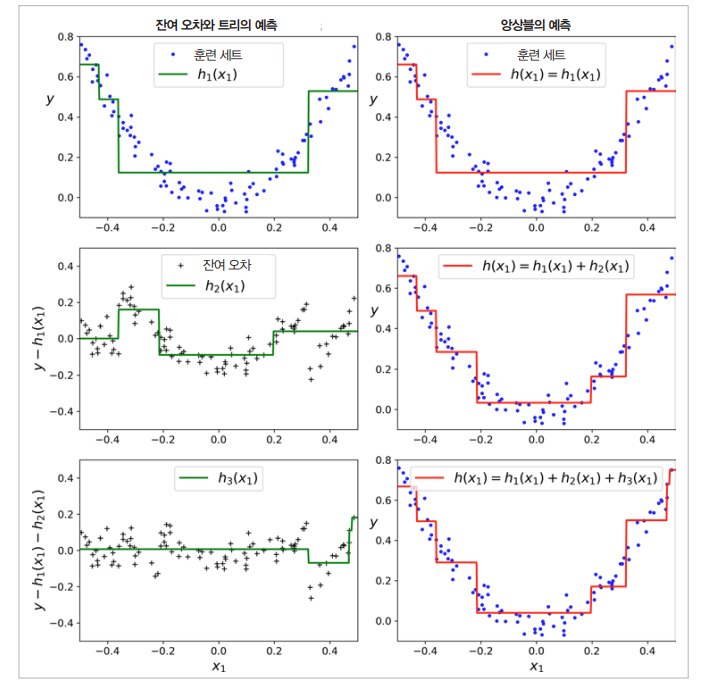

→ 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아짐

In [ ]:
# 사이킷런의 GradientBoostingRegressor 사용하면 GBRT 앙상블을 간단하게 훈련시킬 수 있음
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

* learning_rate 매개변수가 각 트리의 기여 정도를 조절
  * 0.1처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아짐 - 축소 규제 방법


예측기가 부족한 경우(왼쪽)와 너무 많은 경우(오른쪽)의 GBRT 앙상블

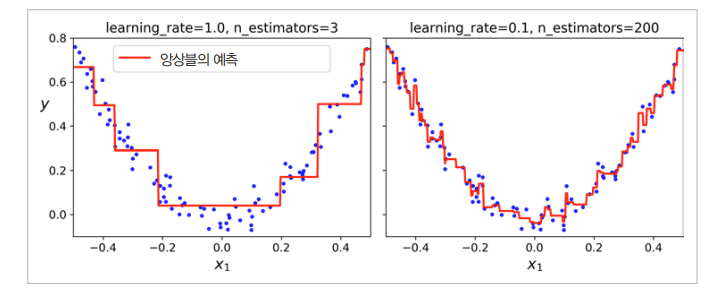

* 최적의 트리 수를 찾기 위해서는 조기 종료 기법을 사용할 수 있음
* 간단하게 구현하려면 staged_predict() 메서드 사용(이 메서드는 훈련의 각 단계(트리 하나, 트리 두 개 등)에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환)

In [ ]:
# 120개의 트리로 GBRT 앙상블 훈련시키고 최적의 트리 수 찾기 위해 각 훈련 단계에서 검증 오차 측정
# 마지막에 최적의 트리 수를 사용해 새로운 GBRT 앙상블 훈련시킴
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=45)

조기 종료를 사용하여 트리 수 튜닝

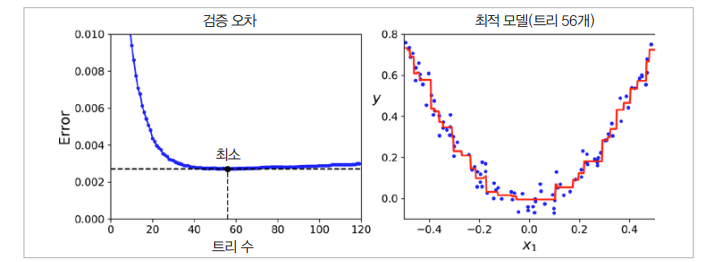

* 실제로 훈련을 중지하는 방법으로 조기 종료를 구현할 수 있음
* warm_start=True로 설정하면 사이킷런이 fit() 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 해줌

In [ ]:
# 연속해서 다섯 번의 반복 동안 검증 오차가 향상되지 않으면 훈련을 멈추는 코드
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break    # 조기 종료

* GradientBoostingRegressor는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개변수 지원(ex. subsample=0.25라고 하면 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습됨)
  * 편향이 높아지는 대신 분산이 낮아지게 되고 또한 훈련 속도를 상당히 높임 - 확률적 그래디언트 부스팅
* 최적화된 그래디언트 부스팅 구현으로 XGBoost(익스트림 그래디언트 부스팅의 약자, extreme gradient boosting) 파이썬 라이브러리 유명

In [ ]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [ ]:
# 자동 조기 종료 기능 제공
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.40289
[1]	validation_0-rmse:0.34259
[2]	validation_0-rmse:0.30534
[3]	validation_0-rmse:0.28180
[4]	validation_0-rmse:0.27254
[5]	validation_0-rmse:0.26575
[6]	validation_0-rmse:0.26677
[7]	validation_0-rmse:0.26496
[8]	validation_0-rmse:0.26704
[9]	validation_0-rmse:0.26706


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


###**7.6 스태킹**

* 스태킹(stacked generalization의 줄임말) - '앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 취합하는 모델을 훈련'의 아이디어로 출발
* 새로운 샘플에 회귀 작업을 수행하는 앙상블에서, 기존의 세 예측기는 각각 다른 값을 예측하고 마지막 예측기(블렌더 또는 메타 학습기)가 이 예측을 입력으로 받아 최종 예측을 만듦

블렌딩 예측기를 사용한 예측 취합

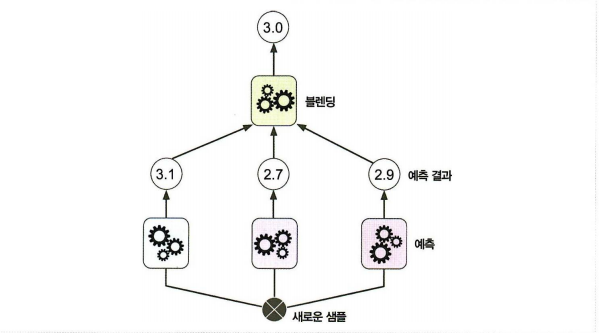

* 블렌더를 학습시키는 일반적인 방법은 홀드 아웃 세트를 사용하는 것
* 먼저 훈련 세트를 두 개의 서브셋으로 나누고, 첫 번째 서브셋은 첫번째 레이어의 예측을 훈련시키기 위해 사용됨

첫 번째 레이어 훈련하기

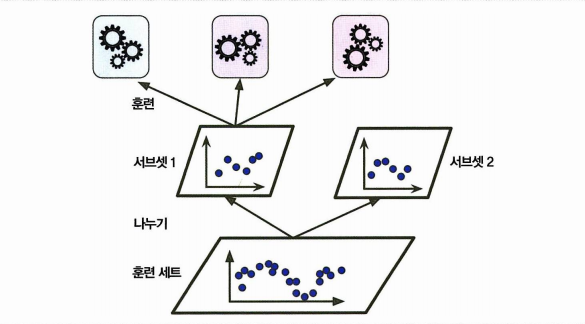

* 그런 다음 첫 번째 레이어의 예측기를 사용해 두 번째(홀드 아웃) 세트에 대한 예측을 만듦
* 예측기들이 훈련하는 동안 이 샘플들을 전혀 보지 못했기 때문에 이때 만들어진 예측은 완전히 새로운 것
* 홀드 아웃 세트의 각 샘플에 대해 세 개의 예측값이 있는데 타깃값은 그대로 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있음(새로운 훈련 세트는 3차원이 됨)
* 블렌더가 새 훈련 세트로 훈련됨(즉 첫 번째 레이어의 예측을 가지고 타깃값을 예측하도록 학습됨)

블렌더 훈련

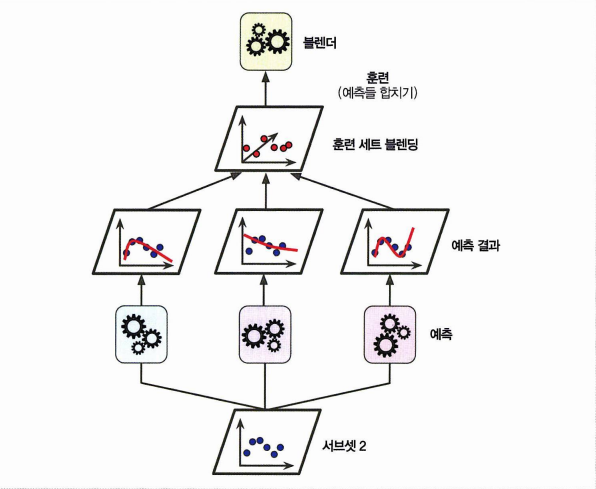

멀티 레이어 스태킹 앙상블의 예측

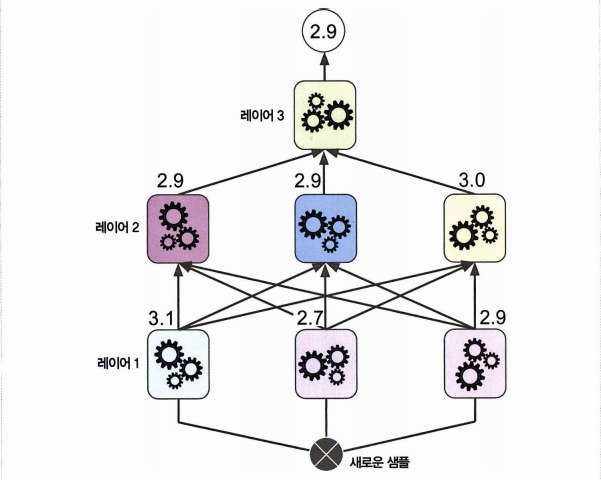